### Sample a volume using a radec space (get_slice_simple) and using a rotated space (get_slice_corrected).

In [1]:
import numpy as np
import sys
from io import BytesIO

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

sys.path.insert(0, '/home/miguel/.local/python_utils/')
sys.path.insert(0, '/home/miguel/.local/python_utils/SDSS/')
from utils_volumes import read_fvolume
from sdss_radec_to_xyz import *
from sdss_get_los import *
import utils_idl as idl
from utils_various import info as info

In [2]:
#--------------------------------------------
#
#--------------------------------------------
def get_slice_simple(vol_den, ra, dec, ra_delta, n_ra=256, n_z=256):
    HubbleParam = 73.0
    c_light     = 300000.0
    
    z1, z2 = 0.001, 0.1  # Initial redshift
    n_z = 256   # Number of steps to compute line of sight
    z_arr = np.arange(z1,z2,(z2-z1)/n_z)
    
    #--- RA range
    ra1 = ra - ra_delta
    ra2 = ra + ra_delta
    ra_arr  = np.arange(ra1,ra2, (ra2-ra1)/n_ra)
    
    ima = np.zeros((n_ra, n_z))
    for i in range(n_ra):
        #--- Compute 3D coordinates of LOS
        xl,yl,zl = sdss_get_los(ra_arr[i],dec,z1,z2,n_z, HubbleParam)    
        #--- Sample volume with LOS
        ima[i,:] = np.power(vol_den[(xl*1024).astype(int),(yl*1024).astype(int),(zl*1024).astype(int)],0.2)

    ima = ima / np.max(ima)*255
    ima = np.transpose(ima)
    return ima

In [3]:
#--------------------------------------------
#   Makes a slice at dec
#--------------------------------------------
def make_dec_slice(_ra, _dec, _ra_delta, _ra_n):
    #--- Make array of ra positions at equator
    ra1 = _ra - _ra_delta
    ra2 = _ra + _ra_delta
    ras  = np.arange(ra1,ra2, (ra2-ra1)/_ra_n) - _ra
    
    #--- From (ra, dec=0) plane to unitary vector
    cx = np.cos(np.deg2rad(dec))*np.cos(np.deg2rad(ras))
    cy = np.cos(np.deg2rad(dec))*np.sin(np.deg2rad(ras))
    cz = ras*0
    
    #--- Rotate to dec position
    cxa,cya,cza = rotate_around_axis(cx, cy, cz,  'Y', -_dec)
    cxr,cyr,czr = rotate_around_axis(cxa,cya,cza, 'Z',  _ra)
        
    #--- Back to ra, dec, convert to degrees
    dec2  = np.rad2deg(np.arcsin(czr))
    ra2   = np.rad2deg(np.arctan2(cyr, cxr))

    #--- Fix angles
    for i,ra_i in enumerate(ras):
        if ra2[i] < 0:
            ra2[i] = ra2[i] + 360
    
    return ra2, dec2

In [4]:
#--------------------------------------------
#
#--------------------------------------------
def get_slice_correct(vol_den, ra, dec, ra_delta, n_ra=256, n_z=256):
    HubbleParam = 73.0
   
    z1, z2 = 0.001, 0.1  # Initial redshift
    z_arr = np.arange(z1,z2,(z2-z1)/n_z)

    #--- Construct correct radec slice
    ra_new, dec_new =  make_dec_slice(ra, dec, ra_delta, n_ra)

    ima = np.zeros((n_ra, n_z))
    for i in range(n_ra):
        #--- Compute 3D coordinates of LOS
        xl,yl,zl = sdss_get_los(ra_new[i],dec_new[i],z1,z2,n_z, HubbleParam)
        #--- Sample volume with LOS
        ima[i,:] = np.power(vol_den[(xl*1024).astype(int),(yl*1024).astype(int),(zl*1024).astype(int)],0.2)

    ima = ima / np.max(ima)*255
    ima = np.transpose(ima)
    return ima

***

In [5]:
PATH_DEN = '/home/miguel/Science/SDSS/SDSS_PhotoWeb/Data/'

#--- Read volume as global variable
vol_den = read_fvolume(PATH_DEN + 'DR13_D_all.128-ens.MASK.WEIGHT.fvol')
print('>>> Reading volume')


>>> Reading volume of size: 1024 512 512
>>> Reading volume


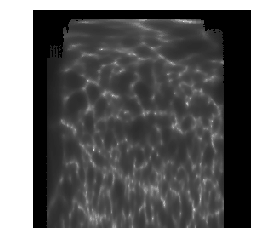

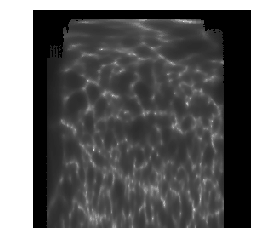

>>> type: <class 'numpy.ndarray'>
    len: 256
    shape: (256, 256)
    min : 0.0
    max : 255.0
    mean: 54.94269172115552
>>> type: <class 'numpy.ndarray'>
    len: 256
    shape: (256, 256)
    min : 0.0
    max : 255.0
    mean: 54.94269172115552


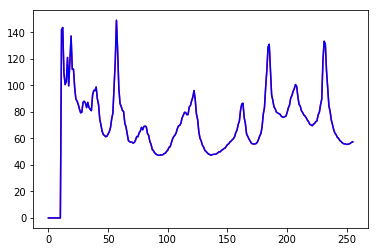

In [8]:
dec = 0

ima1 = get_slice_simple( vol_den, ra=190, dec=dec, ra_delta=80, n_ra=256, n_z=256)
idl.tvscale(ima1)

ima2 = get_slice_correct(vol_den, ra=190, dec=dec, ra_delta=80, n_ra=256, n_z=256)
idl.tvscale(ima2)

info(ima1)
info(ima2)

plt.plot(ima1[:,127],color='red')
plt.plot(ima2[:,127],color='blue')
plt.show()